# Abstract

<p>This notebook first filters frequency files by requiring a minimal amount of coverage for each position. The files that pass QC are saved in a list termed quality_files1 or quality_files2 - depending on the exon</p>

<p>A script for plotting NGS coverage (post-translation and QC) is included below</p>

# Import requirements

In [1]:
from __future__ import division
import glob
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Filter frequency files

In [2]:
def filter_freq_files(wildcard_path, n):
    freq_files = glob.glob(wildcard_path)
    quality_freq_files = []
    passed = 0
    for freq_file in freq_files:
        df = pd.read_csv(freq_file)
        q = sum(df['Coverage'] > 100) / n
        if q >= 0.8:
            #print freq_file.split('/')[-1].split('.')[0],
            passed+=1
            quality_freq_files.append(freq_file)
    print passed, 'files passed QC filter'
    return quality_freq_files

In [3]:
# proportional abundance
wildcard_path1 = '/Users/greg/Desktop/FullNeuroIllumina/Frequency/Tat1/*AAfreq.csv'
quality_files1 = filter_freq_files(wildcard_path1, 70)

wildcard_path2 = '/Users/greg/Desktop/FullNeuroIllumina/Frequency/Tat2/*AAfreq.csv'
quality_files2 = filter_freq_files(wildcard_path2, 12)

59 files passed QC filter
57 files passed QC filter


In [4]:
# raw counts
wildcard_path3 = '/Users/greg/Desktop/FullNeuroIllumina/Frequency/Tat1/*AAfreqcount.csv'
quality_files3 = filter_freq_files(wildcard_path3, 70)

wildcard_path4 = '/Users/greg/Desktop/FullNeuroIllumina/Frequency/Tat2/*AAfreqcount.csv'
quality_files4 = filter_freq_files(wildcard_path4, 12)

59 files passed QC filter
57 files passed QC filter


# Combine frequency files

In [5]:
def drop_positions(df, position):
    df = df[df['AAPos'] <= position]
    return df

def combine_quality_files(quality_files, position):
    freq_files = quality_files
    f = freq_files[0]
    df1 = pd.read_csv(f)
    cols = list(df1.columns)
    main_df = pd.DataFrame(columns=cols)
    for freq_file in freq_files:
        df = pd.read_csv(freq_file)
        main_df = pd.concat([main_df, df], ignore_index=True)
    # sorts dataframe output
    main_df.sort_values(['AAPos','Patient','Visit'],  inplace=True)
    # requires 100x read coverage
    main_df = main_df[main_df['Coverage'] >= 100]
    # drop positions > some position number
    main_df = drop_positions(main_df, position)
    return main_df

In [6]:
combo_df1 = combine_quality_files(quality_files1, 72)
combo_df2 = combine_quality_files(quality_files2, 29)
combo_df2['AAPos'] = combo_df2['AAPos'] + 72
combo_df = pd.concat([combo_df1, combo_df2], ignore_index=True)
print combo_df.shape
combo_df.head()

(5809, 25)


,Patient,Visit,Prot,AAPos,Coverage,A,R,N,D,C,...,L,K,M,F,P,S,T,W,Y,V
0,A0001,R09,Tat1,1,38938,0.000051,0.002157,0.000051,0.000077,0.002080,...,0.006934,0.001695,0.565052,0.000026,0,0.000848,0.000128,0.416637,0,0.000205
1,A0010,R08,Tat1,1,171,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005848,0.005848,0.584795,0.000000,0,0.000000,0.000000,0.403509,0,0.000000
2,A0013,R09,Tat1,1,602,0.000000,0.001661,0.000000,0.000000,0.000000,...,0.001661,0.004983,0.282392,0.000000,0,0.001661,0.000000,0.209302,0,0.000000
3,A0019,R12,Tat1,1,1485,0.000000,0.001347,0.000673,0.000000,0.000673,...,0.008081,0.003367,0.526599,0.000000,0,0.001347,0.000673,0.452525,0,0.000000
4,A0026,R09,Tat1,1,334,0.000000,0.002994,0.000000,0.000000,0.000000,...,0.008982,0.000000,0.589820,0.000000,0,0.002994,0.000000,0.389222,0,0.000000


In [7]:
combo_counts_df1 = combine_quality_files(quality_files3, 72)
combo_counts_df2 = combine_quality_files(quality_files4, 29)
combo_counts_df2['AAPos'] = combo_counts_df2['AAPos'] + 72
combo_counts_df = pd.concat([combo_counts_df1, combo_counts_df2], ignore_index=True)
print combo_counts_df.shape
combo_counts_df.head()

(5809, 25)


,Patient,Visit,Prot,AAPos,Coverage,A,R,N,D,C,...,L,K,M,F,P,S,T,W,Y,V
0,A0001,R09,Tat1,1,38938,2,84,2,3,81,...,270,66,22002,1,0,33,5,16223,0,8
1,A0010,R08,Tat1,1,171,0,0,0,0,0,...,1,1,100,0,0,0,0,69,0,0
2,A0013,R09,Tat1,1,602,0,1,0,0,0,...,1,3,170,0,0,1,0,126,0,0
3,A0019,R12,Tat1,1,1485,0,2,1,0,1,...,12,5,782,0,0,2,1,672,0,0
4,A0026,R09,Tat1,1,334,0,1,0,0,0,...,3,0,197,0,0,1,0,130,0,0


# Save NGS summary to file

In [8]:
# proportional abundance
combo_df1.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGSprofile1.csv', index=False)
combo_df2.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGSprofile2.csv', index=False)
combo_df.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGSprofile.csv', index=False)

# raw counts
combo_counts_df1.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGScounts1.csv', index=False)
combo_counts_df2.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGScounts2.csv', index=False)
combo_counts_df.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/NGScounts.csv', index=False)

# NGS coverage figure

In [9]:
ngs_seq_metadata = {'position':[], 'samples':[], 'mean log coverage':[], 'std log coverage':[]}

for i, g in combo_df.groupby('AAPos'):
    ngs_seq_metadata['mean log coverage'].append(np.mean(np.log10(g['Coverage'])))
    ngs_seq_metadata['std log coverage'].append(np.std(np.log10(g['Coverage'])))
    ngs_seq_metadata['samples'].append(g.shape[0])
    ngs_seq_metadata['position'].append(i)
    
ngs_seq_meta_df = pd.DataFrame(ngs_seq_metadata)
ngs_seq_meta_df.to_csv('/Users/greg/Desktop/FullNeuroIllumina/NGSProfiles/ngs_seq_meta_df.csv', index=False)

In [58]:
indiv_cov = []

for i, g in combo_df.groupby(['Patient','Visit']):
    x = g[['AAPos','Coverage']]
    cov = [0]
    for i in range(1,102):
        x = g[['AAPos','Coverage']]
        #x[x['AAPos'] == i]
        if i in list(x['AAPos']):
            c = np.log10(list(x[x['AAPos']==i]['Coverage'])[0])
        else:
            c = 0
        cov.append(c)
    indiv_cov.append(cov)

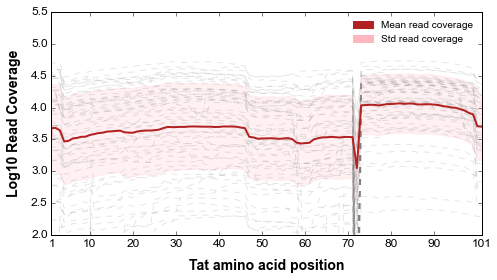

In [59]:
# set fonts
mpl.rc('font',family='Arial')

fig, ax = plt.subplots(figsize=(7,4))
L = list(ngs_seq_meta_df['mean log coverage'])
L2 = [0] + L
E = list(ngs_seq_meta_df['std log coverage'])
E2 = [0] + E
y = np.array(L2)
x = np.arange(len(L2))

# plot it
ax.tick_params(axis='both',labelsize=12)

for c in indiv_cov:
    ax.plot(np.arange(len(c)), np.array(c), color='gray', ls='--', alpha=0.2)


ax.plot(x, y, linewidth=2, color='firebrick')
yerr = E2
ax.fill_between(x, y-yerr, y+yerr,facecolor='lightpink',edgecolor='lightpink',alpha=0.2)

ax.set_ylabel('Log10 Read Coverage',size=14, labelpad=10, weight='bold')
ax.set_ylim([2,5.5])

ax.set_xlabel('Tat amino acid position', size=14, labelpad=10, weight='bold')
xs = [1,10,20,30,40,50,60,70,80,90,101]
ax.set_xticks(xs)
ax.set_xlim([1,101])

ax.legend([mpl.patches.Patch(color='firebrick'),
           mpl.patches.Patch(color='lightpink')],
           ['Mean read coverage', 'Std read coverage'],
           loc=1, ncol=1, fancybox=False, frameon=False,
           fontsize=10)

plt.tight_layout()
plt.show()
fig.savefig('/Users/greg/Desktop/FullNeuroIllumina/Figures/GDSIlluminaCoverage.png',
            format='png', dpi=300, bbox_inches='tight')